In [1]:
import sys
sys.path.append('../../code')
import deepxde as dde
import matplotlib.pyplot as plt
import numpy as np
# Import tf if using backend tensorflow.compat.v1 or tensorflow
from deepxde.backend import tf
#import deepxde

Using backend: tensorflow
Other supported backends: tensorflow.compat.v1, pytorch, jax, paddle.
paddle supports more examples now and is recommended.


## 1D Poisson Dirichlet

In [2]:
from keras.models import Sequential
from keras.layers import Dense

M = 100
Rm = 2
d=1

weight = np.zeros((M,d))
biases = np.zeros((M,1))

for i in range(M):
    for j in range(d):
        weight[i][j]= np.random.uniform(low=-Rm, high=Rm)
    biases[i] = np.random.uniform(low=-0.0005, high=0.0005)

def phi(x):
    #out = np.zeros((np.shape(x)[0],M))
    bias = np.repeat(biases, np.shape(x)[1], axis = -1)
    out = np.sin(weight@x + bias)
    return out

xx = np.zeros((1,10))

print(np.shape(phi(xx)))
print(np.shape(weight))
print(np.shape(biases))


(100, 10)
(100, 1)
(100, 1)


In [3]:
train = np.array([np.linspace(-1, 1, 20)])
test = np.array([np.linspace(-1, 1, 7)])
print(np.shape(train))

def func(x):
    return np.sin(np.pi * x)
    
y_train = func(train).T

y_test = func(test).T

(1, 20)


In [4]:
k_init = tf.keras.initializers.RandomUniform(minval=-Rm, maxval=Rm)
b_init = tf.keras.initializers.RandomUniform(minval=-0.0005, maxval=0.0005)
def custom_activation(x):
    return tf.sin(x)

model = Sequential()
#layer1 = Dense(M, activation=custom_activation)

model.add(Dense(M, activation=custom_activation, input_dim=d, kernel_initializer=k_init,bias_initializer=b_init, trainable=False))
model.add(Dense(1))
model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer='adam', 
                metrics=[tf.keras.losses.MeanAbsoluteError(reduction="auto", name="mean_absolute_error"),'accuracy'])

In [5]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=100)
history = model.fit(train.T, y_train, validation_data = (test.T,y_test), epochs=2000, batch_size=64, callbacks=[callback])

Epoch 1/2000
1/1 [==============================] - 1s 559ms/step - loss: 1.0029 - mean_absolute_error: 0.7548 - accuracy: 0.0000e+00 - val_loss: 1.2444 - val_mean_absolute_error: 0.8455 - val_accuracy: 0.1429
Epoch 2/2000
1/1 [==============================] - 0s 30ms/step - loss: 0.9197 - mean_absolute_error: 0.7149 - accuracy: 0.0000e+00 - val_loss: 1.1459 - val_mean_absolute_error: 0.8035 - val_accuracy: 0.1429
Epoch 3/2000
1/1 [==============================] - 0s 29ms/step - loss: 0.8407 - mean_absolute_error: 0.6751 - accuracy: 0.0000e+00 - val_loss: 1.0522 - val_mean_absolute_error: 0.7618 - val_accuracy: 0.1429
Epoch 4/2000
1/1 [==============================] - 0s 33ms/step - loss: 0.7658 - mean_absolute_error: 0.6354 - accuracy: 0.0000e+00 - val_loss: 0.9633 - val_mean_absolute_error: 0.7202 - val_accuracy: 0.1429
Epoch 5/2000
1/1 [==============================] - 0s 33ms/step - loss: 0.6952 - mean_absolute_error: 0.5963 - accuracy: 0.0000e+00 - val_loss: 0.8793 - val_mean_

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               200       
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 301
Trainable params: 101
Non-trainable params: 200
_________________________________________________________________
None


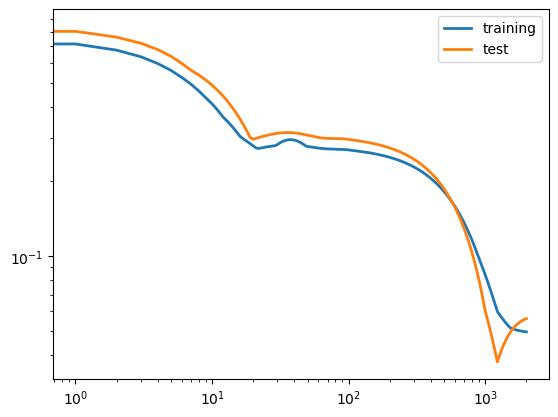

In [6]:
print(model.summary())
bc     = history.history['mean_absolute_error']
bc_val     = history.history['val_mean_absolute_error']

plt.loglog(range(np.shape(bc)[0]),bc, linewidth=2, label='training')
plt.loglog(range(np.shape(bc_val)[0]),bc_val, linewidth=2, label='test')
plt.legend()
plt.show()

4/4 [==============================] - 0s 2ms/step


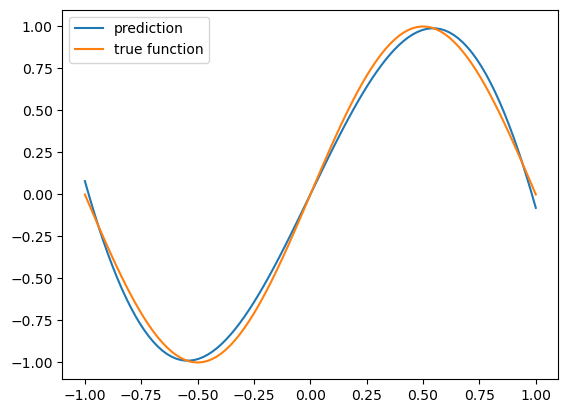

In [7]:
val = np.linspace(-1, 1, 100)

y_pred = model.predict(val)
plt.plot(val, y_pred, label='prediction')
plt.plot(val, func(val), label='true function')
plt.legend()

### PINN random

In [78]:
import sys
sys.path.append('../../code')
import deepxde as dde
import matplotlib.pyplot as plt
import numpy as np
# Import tf if using backend tensorflow.compat.v1 or tensorflow
from deepxde.backend import tf

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

from keras.models import Sequential
from keras.layers import Dense

In [79]:
pi = np.pi

def func(x):
    return np.sin(np.pi * x)
    #return np.sin(3*pi*x + 3*pi/20)*np.cos(2*pi*x + pi/10) + 2


def fun_u_b(x):
    n = x.shape[0]

    return tf.zeros((n,1))
    #u_low = [func(-1.)]
    #u_up = [func(1.)]
    #return tf.constant([u_low, u_up])

# Define residual of the PDE
def fun_r(x, u, u_x, u_xx):
    return -u_xx - np.pi ** 2 * tf.sin(np.pi * x)  # residuo seno
    #return -u_xx - 13*pi**2*tf.sin(3*pi*x + 3*pi/20)*tf.cos(2*pi*x + pi/10) - 12*pi**2*tf.cos(3*pi*x + 3*pi/20)*tf.sin(2*pi*x + pi/10)

In [80]:
# Set number of data points
N_b = 2
N_r = 20

# Set boundary
xmin = -1.
xmax = 1.

# Lower bounds
lb = tf.constant([xmin])
# Upper bounds
ub = tf.constant([xmax])

# Set random seed for reproducible results
tf.random.set_seed(0)

# Boundary data
'''x_b = lb[0] + (ub[0] - lb[0]) * tf.keras.backend.random_bernoulli((N_b,1), 0.5)
X_b = tf.concat([x_b], axis=1)'''
x_b = tf.constant([xmin, xmax])
# Evaluate boundary condition at (t_b,x_b)
u_b = fun_u_b(x_b)

x_b = tf.constant(u_b)
# Draw uniformly sampled collocation points
x_r = tf.random.uniform((N_r,1), lb[0], ub[0])
'''x_r = np.linspace(xmin, xmax, N_r, dtype='float32')
xx = []
for i in range(N_r):
    xx.append([x_r[i]])
x_r = tf.constant(xx)'''
X_r = tf.concat([x_r], axis=1)

# Collect boundary and inital data in lists
X_data = [x_b]
u_data = [u_b]

In [145]:
d = 1
Rm = 4
M = 600
k_init = tf.keras.initializers.RandomUniform(minval=-Rm, maxval=Rm)
b_init = tf.keras.initializers.RandomUniform(minval=-0.0005, maxval=0.0005)
def custom_activation(x):
    return tf.sin(x)

model2 = Sequential()
#layer1 = Dense(M, activation=custom_activation)

model2.add(Dense(M, activation=custom_activation, input_dim=d, kernel_initializer=k_init,bias_initializer=b_init, trainable=False))
model2.add(Dense(1))

def get_r(model2, X_r):
    
    # A tf.GradientTape is used to compute derivatives in TensorFlow
    with tf.GradientTape(persistent=True) as tape:
        # Split t and x to compute partial derivatives
        x = X_r[:, 0:1]

        # Variables t and x are watched during tape
        # to compute derivatives u_t and u_x
        tape.watch(x)

        # Determine residual 
        u = model2(tf.stack([x[:,0]], axis=1))

        # Compute gradient u_x within the GradientTape
        # since we need second derivatives
        u_x = tape.gradient(u, x)
            
    u_xx = tape.gradient(u_x, x)

    del tape

    return fun_r(x, u, u_x, u_xx)

def compute_loss(model2, X_r, X_data, u_data):
    
    # Compute phi^r
    r = get_r(model2, X_r)
    phi_r = tf.reduce_mean(tf.square(r))
    
    # Initialize loss
    loss = phi_r
    #loss = 0
    #u_da = tf.cast(u_data, tf.float32)

    #u_pred1 = model2(X_data[0])
    #u_pred2 = model2(X_data[-1])
    #loss += tf.reduce_mean(tf.square(u_data[0] - u_pred1))
    #loss += tf.reduce_mean(tf.square(u_data[-1] - u_pred2))
    # Add phi^0 and phi^b to the loss
    for i in range(len(X_data)):
        u_pred = model2(X_data[i])
        loss += tf.reduce_mean(tf.square(u_data[i] - u_pred))
    
    return loss

def get_grad(model2, X_r, X_data, u_data):
    
    with tf.GradientTape(persistent=True) as tape:
        # This tape is for derivatives with
        # respect to trainable variables
        tape.watch(model2.trainable_variables)
        loss = compute_loss(model2, X_r, X_data, u_data)

    g = tape.gradient(loss, model2.trainable_variables)
    del tape

    return loss, g


lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([1000,3000],[1e-2,1e-3,5e-4])

# Choose the optimizer
optim = tf.keras.optimizers.Adam(learning_rate=0.0001)

from time import time

# Define one training step as a TensorFlow function to increase speed of training
@tf.function
def train_step():
    # Compute current loss and gradient w.r.t. parameters
    loss, grad_theta = get_grad(model2, X_r, X_data, u_data)
    
    # Perform gradient descent step
    optim.apply_gradients(zip(grad_theta, model2.trainable_variables))
    
    return loss

# Number of training epochs
N = 10000
hist = []

# Start timer
t0 = time()

for i in range(N+1):
    
    loss = train_step()
    
    # Append current loss to hist
    hist.append(loss.numpy())
    
    # Output current loss after 50 iterates
    if i%50 == 0:
        print('It {:05d}: loss = {:10.8e}'.format(i,loss))
        
# Print computation time
print('\nComputation time: {} seconds'.format(time()-t0))

It 00000: loss = 1.25692682e+01
It 00050: loss = 8.44773650e-01
It 00100: loss = 3.42477448e-02
It 00150: loss = 4.91329189e-03
It 00200: loss = 4.76776902e-03
It 00250: loss = 4.67621814e-03
It 00300: loss = 4.57646418e-03
It 00350: loss = 4.46904404e-03
It 00400: loss = 4.35502967e-03
It 00450: loss = 4.23528720e-03
It 00500: loss = 4.11054306e-03
It 00550: loss = 3.98162473e-03
It 00600: loss = 3.84932873e-03
It 00650: loss = 3.71416961e-03
It 00700: loss = 3.57692828e-03
It 00750: loss = 3.43812304e-03
It 00800: loss = 3.29833850e-03
It 00850: loss = 3.15814209e-03
It 00900: loss = 3.01806396e-03
It 00950: loss = 2.87854485e-03
It 01000: loss = 2.73997523e-03
It 01050: loss = 2.60296767e-03
It 01100: loss = 2.46782787e-03
It 01150: loss = 2.33486714e-03
It 01200: loss = 2.20457162e-03
It 01250: loss = 2.07712292e-03
It 01300: loss = 1.95293687e-03
It 01350: loss = 1.83224864e-03
It 01400: loss = 1.71527429e-03
It 01450: loss = 1.60216237e-03
It 01500: loss = 1.49313058e-03
It 01550

4/4 [==============================] - 0s 934us/step


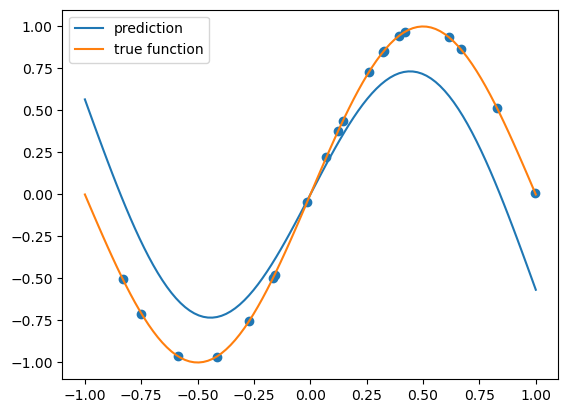

In [146]:
y_r = func(x_r)

val = np.linspace(xmin, xmax, 100)

y_pred = model2.predict(val)
plt.plot(val, y_pred, label='prediction')
plt.plot(val, func(val), label='true function')
plt.scatter(x_r, y_r)
plt.legend()

### Deepxde random

In [61]:
import sys
sys.path.append('../../code')
import deepxde as dde
import matplotlib.pyplot as plt
import numpy as np
# Import tf if using backend tensorflow.compat.v1 or tensorflow
from deepxde.backend import tf
#import deepxde

In [181]:
def pde(x, y):
    dy_xx = dde.grad.hessian(y, x)
    # Use tf.sin for backend tensorflow.compat.v1 or tensorflow
    #return -dy_xx - np.pi ** 2 * tf.sin(np.pi * x)
    return -dy_xx - 13*pi**2*tf.sin(3*pi*x + 3*pi/20)*tf.cos(2*pi*x + pi/10) - 12*pi**2*tf.cos(3*pi*x + 3*pi/20)*tf.sin(2*pi*x + pi/10)

def boundary(x, on_boundary):
    return on_boundary


def func(x):
    #return np.sin(np.pi * x)
    return np.sin(3*pi*x + 3*pi/20)*np.cos(2*pi*x + pi/10) + 2


geom = dde.geometry.Interval(-0.5, 0)
bc = dde.icbc.DirichletBC(geom, func, boundary)
data = dde.data.PDE(geom, pde, bc, 16, 2, solution=func, num_test=100)


In [63]:
bcs = bc if isinstance(bc, (list, tuple)) else [bc]
for i, b in enumerate(bcs):
    print(i, b)

0 <deepxde.icbc.boundary_conditions.DirichletBC object at 0x000001EF4B33A550>


In [186]:
M =200
layer_size = [1] + [M]  + [10] + [1]

activation = ["sin", 'sin', 'linear']

initializer = "Glorot uniform"

net = dde.nn.FNN_copy(layer_size, activation, initializer, Rm=10)

In [5]:
np.cumsum([0] + [7])

array([0, 7], dtype=int32)

In [187]:
model = dde.Model(data, net)
model.compile("adam", lr=0.001, metrics=["l2 relative error"])

losshistory, train_state = model.train(iterations=10000)

Compiling model...
'compile' took 0.000567 s

Training model...

[2]
[0, 2]
[<tf.Tensor 'sub_1:0' shape=(20, 1) dtype=float32>]
[2]
[0, 2]
[<tf.Tensor 'sub_1:0' shape=(20, 1) dtype=float32>]
[2]
[0, 2]
[<tf.Tensor 'sub_1:0' shape=(102, 1) dtype=float32>]
Step      Train loss              Test loss               Test metric   
0         [6.60e+03, 3.37e+01]    [6.53e+03, 3.37e+01]    [9.34e-01]    
1000      [6.60e+03, 4.02e-01]    [6.53e+03, 4.02e-01]    [2.07e-01]    
2000      [6.58e+03, 5.16e-02]    [6.56e+03, 5.16e-02]    [2.35e-01]    
3000      [2.53e-01, 3.99e-01]    [2.10e-01, 3.99e-01]    [7.16e-02]    
4000      [7.24e-02, 1.32e-02]    [6.00e-02, 1.32e-02]    [1.38e-02]    
5000      [6.34e-02, 4.33e-05]    [5.46e-02, 4.33e-05]    [8.89e-04]    
6000      [4.70e-02, 1.39e-05]    [3.66e-02, 1.39e-05]    [4.01e-04]    
7000      [5.21e-02, 8.23e-06]    [3.38e-02, 8.23e-06]    [3.72e-04]    
8000      [3.23e-02, 3.00e-07]    [2.54e-02, 3.00e-07]    [9.85e-05]    
9000      [2.78

Saving loss history to c:\Users\Marco\Documents\GitHub\pacs\code\my_ex\loss.dat ...
Saving training data to c:\Users\Marco\Documents\GitHub\pacs\code\my_ex\train.dat ...
Saving test data to c:\Users\Marco\Documents\GitHub\pacs\code\my_ex\test.dat ...


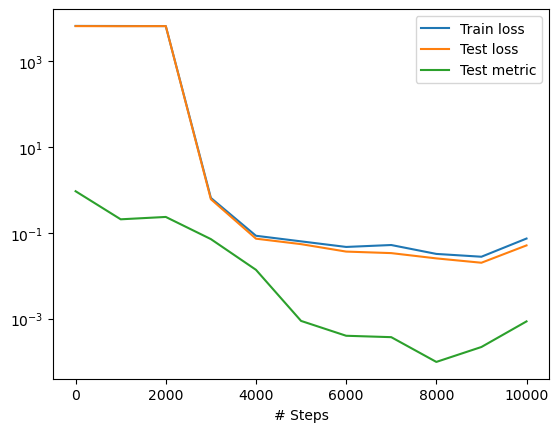

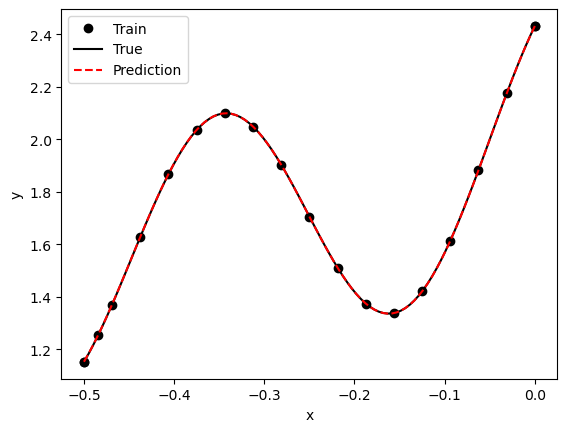

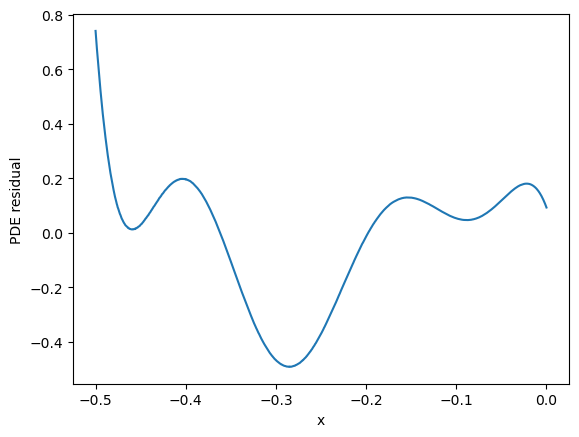

In [188]:
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

x = geom.uniform_points(1000, True)
y = model.predict(x, operator=pde)
plt.figure()
plt.plot(x, y)
plt.xlabel("x")
plt.ylabel("PDE residual")
plt.show()